<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Utilizing the Prior Function

Author(s): Paul Miles | Date Created: July 19, 2019

When using [pymcmcstat](https://github.com/prmiles/pymcmcstat/wiki) the user can specify the prior function.  The package by default assumes uniform prior distributions.  This is recommended as it prevents introducing any form of bias into your sampling.  However, in many cases information is known _a priori_ about a particular parameter.  This knowledge may come from an expert or from other experimental study.  The user can enforce this information by defining the prior mean and standard deviation when initializing the parameter.  Furthermore, a custom prior function can be defined, although this should be used with caution.  This tutorial will outline how to define a prior distribution and also how to use a custom prior function in order to enforce non-linear parameter constraints.

In [1]:
# import required packages
from pymcmcstat.MCMC import MCMC
import numpy as np
import mcmcplot.mcmatplot as mcpl
import matplotlib.pyplot as plt
from scipy.stats import norm
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore');

1.9.0


# Define Model and Sum-of-Squares Functions

In [2]:
# define test model function
def modelfun(xdata, theta):
    m = theta[0]
    b = theta[1]
    nrow, ncol = xdata.shape
    y = np.zeros([nrow, 1])
    y[:,0] = m*xdata.reshape(nrow,) + b
    return y

def test_ssfun(theta, data):
    xdata = data.xdata[0]
    ydata = data.ydata[0]
    # eval model
    ymodel = modelfun(xdata, theta)
    # calc sos
    ss = sum((ymodel[:, 0] - ydata[:, 0])**2)
    return ss

## Define Test Data Set - Plot
We define our test data set, then plot the data and model response.  We also plot the residual to check the validity of our statistical model.

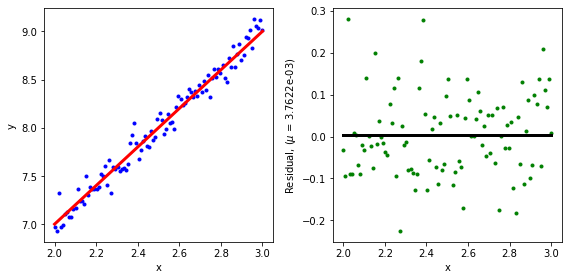

In [4]:
nds = 100
m = 2
b = 3
x = np.linspace(2, 3, num=nds).reshape(nds, 1)
y = m*x + b + 0.1*np.random.standard_normal(x.shape)
res = y - modelfun(x, [m, b])
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(x, y, '.b');
plt.plot(x, modelfun(x, [m, b]), '-r', linewidth=3);
plt.xlabel('x'); plt.ylabel('y');
plt.subplot(1, 2, 2)
plt.plot(x, res, '.g');
mr = res.mean()
plt.plot([x[0], x[-1]], [mr, mr], '-k', linewidth=3)
plt.xlabel('x')
plt.ylabel(str('Residual, ($\\mu$ = {:5.4e})'.format(mr)));
plt.tight_layout()

# Run MCMC Simulation With Normal Prior Distribution
Suppose we have prior knowledge that the slope has a mean value of 2 and a standard deviation of 0.25.  We can apply this knowledge when initializing the parameter.

## Initialize MCMC Object and Setup Simulation
- Note how the `prior_mu` and `prior_sigma` arguments are defined when initializing `m`.

In [5]:
mcstat = MCMC()
# Add data
mcstat.data.add_data_set(x, y)
# Define simulation options and model settings
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5.0e4),
    updatesigma=True)
mcstat.model_settings.define_model_settings(sos_function=test_ssfun)
# Define model parameters
mcstat.parameters.add_model_parameter(
    name='m',
    theta0=2.0,
    prior_mu=2,
    prior_sigma=0.05)
mcstat.parameters.add_model_parameter(
    name='b',
    theta0=2.0)

## Run Simulation

In [6]:
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
names = results['names']
# define burnin
burnin = int(results['nsimu']/2)
# display chain statistics
mcstat.chainstats(chain[burnin:, :], results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      2.00 [     -inf,       inf] N(     2.00,     0.05^2)
         b:      2.00 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 50000 of 50000 complete in 10.9 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
m         :     2.0231     0.0275     0.0005     8.4820     0.9997
b         :     2.9459     0.0696     0.0014     8.3792     0.9996
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 20.74%
Stage 2: 53.89%
Net    : 74.63% -> 37316/50000
---------------
Chain provided:
Net    : 80.56% -> 20140/25000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


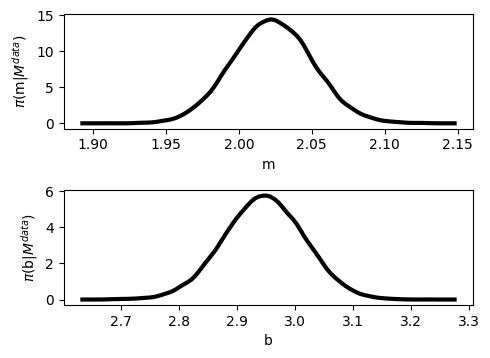

In [9]:
from pymcmcstat import mcmcplot as mcp
figs = mcp.plot_density_panel(chains=chain[burnin:, :],
                                   names=names)

## Discussion
We see from the posterior densities and displayed statistics, that the distribution for `m` is narrower than what was defined in the prior distribution.  This is not unexpected as we have provided new data to inform that parameter value.  The prior distribution was very narrow, which can potentially lead to bias.  In general, using a non-informative prior (uniform) is the recommended procedure; however, there are many real problems that may require using narrow priors.

# Run MCMC Simulation with Custom Prior Function
We can define a custom prior function to enforce non-linear parameter constraints.  This approach should be used with caution as it is not applicable or practicle for every problem.

## Define Custom Prior Function
The default prior function inside [pymcmcstat](https://prmiles.wordpress.ncsu.edu/codes/python-packages/pymcmcstat/) is
```python
def default_priorfun(theta, mu, sigma):
    res = (mu - theta)/sigma
    pf = np.dot(res.reshape(1,res.size), res.reshape(res.size,1))
    return pf
```
Mathematically, what this function is calculating is actually the arguments in large parantheses in the exponential function.
$$
\pi_0(\theta) = \exp\Big[-\frac{1}{2}\Big(\frac{(\mu - \theta)^2}{\sigma^2}\Big)\Big]
$$
The argument is evaluated in the exponential function when calculating the acceptance ratio in the Metropolis algorithm.  Note, a uniform prior function corresponds to the case where $\sigma = \infty$, which is the default.  You can observe this when running the simulation and displaying the initial parameter settings.

In defining a custom prior function, we still want the same basic behavior as the default.  For example, if we expect both model parameters to have the same sign, then we can define a custom prior function as follows:

In [10]:
def test_priorfun(theta, mu, sigma):
    if theta[1]*theta[0] < 0:
        return np.array([np.inf])
    else:
        res = (mu - theta)/sigma
        return np.dot(res.reshape(1, res.size),
                      res.reshape(res.size, 1))

## Initialize MCMC Object and Setup Simulation
- Assign custom prior function when defining the model settings.

In [11]:
mcstat = MCMC()
# Add data
mcstat.data.add_data_set(x, y)
# Define simulation options and model settings
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5.0e4),
    updatesigma=True)
mcstat.model_settings.define_model_settings(sos_function=test_ssfun,
                                            prior_function=test_priorfun)
# Define model parameters
mcstat.parameters.add_model_parameter(
    name='m',
    theta0=2.0,
    prior_mu=2,
    prior_sigma=0.05)
mcstat.parameters.add_model_parameter(
    name='b',
    theta0=2.0)

## Run Simulation

In [12]:
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
names = results['names']
# define burnin
burnin = int(results['nsimu']/2)
# display chain statistics
mcstat.chainstats(chain[burnin:, :], results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      2.00 [     -inf,       inf] N(     2.00,     0.05^2)
         b:      2.00 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 50000 of 50000 complete in 10.8 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
m         :     2.0235     0.0279     0.0005     8.2884     0.9998
b         :     2.9451     0.0705     0.0014     8.1521     0.9995
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 22.26%
Stage 2: 53.58%
Net    : 75.83% -> 37917/50000
---------------
Chain provided:
Net    : 81.21% -> 20302/25000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


## Check If Prior Function Worked
If the prior function worked properly, then we should find that no rows in the chain break the prior conditions.  In this case, we check that the parameters always have the same sign.  If any row  didn't satisfy this requirement, than we would expect the summation of this logical vector to be nonzero.

In [13]:
tmp = chain[:, 1]*chain[:, 0] < 0
print(sum(tmp))

0


Compare with Simulation Using Default Prior Function

In [15]:
# Initialize MCMC object
mcstat = MCMC()
# Add data
mcstat.data.add_data_set(x, y)
# Define simulation options and model settings
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5.0e3),
    updatesigma=True,
    method='dram',
    verbosity=1,
    printint=100,
    )
mcstat.model_settings.define_model_settings(sos_function=test_ssfun)
# Define model parameters
mcstat.parameters.add_model_parameter(name='m', theta0=-2)
mcstat.parameters.add_model_parameter(name='b', theta0=-2)
# run simulation
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
names = results['names']
# define burnin
burnin = int(results['nsimu']/2)
# display chain statistics
mcstat.chainstats(chain[burnin:, :], results)
tmp = chain[:, 1]*chain[:, 0] < 0
print('Number of accepted values that broken prior constrain: {}'.format(sum(tmp)))


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:     -2.00 [     -inf,       inf] N( 0.00e+00,      inf)
         b:     -2.00 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 1.2 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
m         :     2.0456     0.0301     0.0050    96.7168     0.9787
b         :     2.8901     0.0775     0.0133   105.9057     0.9599
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 1.24%
Stage 2: 1.98%
Net    : 3.22% -> 161/5000
---------------
Chain provided:
Net    : 1.24% -> 31/2500
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------
Number of accepted values that broken p

## Discussion
The prior function successfully forced the simulation to reject proposed parameter sets that violated the condition, $\theta_1\times\theta_2 >= 0$.  When using the default prior function, we see that many samples were in fact accepted.  This shows from a mechanistic standpoint, that the custom prior function is doing what we want it to.  That said, it must be noted that this solution is going to be specific to every problem, and it may impact your statistical model.  This is the simplest procedure for applying non-linear parameter constraints, but it should be used with caution.